# Регуляризация

Модели глубокого обучения обладают такой большой гибкостью и возможностями, что **переобучение может стать серьезной проблемой**, если набор данных обучения недостаточно велик. 


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases_v3_reg_check import *
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # plots size
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Постановка задачи**: вы только что были наняты в качестве эксперта по искусственному интеллекту французской футбольной корпорацией. Они хотели бы, чтобы вы порекомендовали позиции, где вратарь сборной Франции должен бить по мячу, чтобы игроки французской команды могли затем ударить его головой.

<img src="https://user-images.githubusercontent.com/54672403/84264212-76997a00-ab29-11ea-9eef-55d6ace83194.png" style="width:600px;height:350px;">
<caption><center> **Футбольное поле**<br>вратарь пинает мяч в воздухе, игроки каждой команды борются, чтобы ударить по мячу головой</center></caption>

Они дают вам следующий 2D-набор данных из последних 10 игр Франции.

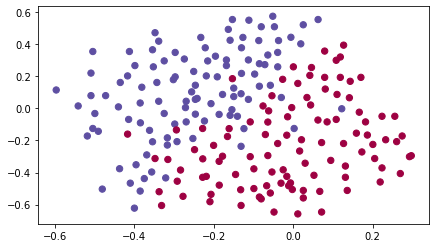

In [13]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Каждая точка соответствует положению на футбольном поле, в котором футболист ударил головой по мячу после того, как французский вратарь выстрелил по мячу с левой стороны футбольного поля.
- Если точка синяя, то это означает, что французский игрок успел ударить по мячу головой
- Если точка красная, это означает, что игрок другой команды ударил по мячу головой

**Ваша цель**: используйте модель глубокого обучения, чтобы найти позиции на поле, куда вратарь должен бить мяч.


**Анализ набора данных**: этот набор данных немного зашумлен, но похоже, что диагональная линия, отделяющая верхнюю левую половину (синюю) от нижней правой половины (красной), будет хорошо работать.

Сначала вы попробуете использовать нерегуляризованную модель. Затем вы узнаете, как регулизовать данные и решить, какую модель вы выберете для решения проблемы французской футбольной корпорации.

## Non-regularized model

Вы будете использовать следующую нейронную сеть (уже реализованную для вас ниже). Эта модель может быть использована:
- в режиме регуляризации ( *regularization mode*) - путем установки входного сигнала `lambd` на ненулевое значение. 
- в режиме *dropout* (*dropout mode* ) -- установив значение `keep_prob` меньше единицы

Сначала вы попробуете модель без какой-либо регуляризации. Затем вы будете реализовывать:
- *Регуляризация L2* -- функции: `compute_cost_with_regularization()` и `backward_propagation_with_regularization()`
- *Dropout* -- функции: `forward_propagation_with_dropout()` и `backward_propagation_with_dropout()`"

In [14]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Реализует трехслойную нейронную сеть: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    X -- входные дданные shape =  (2, количество примеров)
    Y -- целевые переменные {0 - red dots; 1 - blue dots}, shape =  (1, количество примеров)
    learning_rate -- скорость обучения для обновления градиентного спуска
    num_iterations -- количество итераций цикла оптимизации
    print_cost -- если True, то он печатает cost каждые 100 шагов
    lambd --  гиперпараметр регуляризации, скаляр
    keep_prob - вероятность сохранения нейрона активным во время отсева, скаляр.
    
    returns: parameters - параметры, изучаемые моделью. Затем они могут быть использованы для предсказания.
    """
    
    grads = {}
    costs = [] # чтобы отслеживать потери
    m = X.shape[1] # количество примеров
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Init parameters dict.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1) # можно использовать как регуляризацию L2, так и dropout,
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 10000 == 0:
            print(f"Cost after iteration {i}: {cost:.4}")
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Давайте тренировать модель без какой-либо регуляризации и наблюдать точность на тренеровачных/тестовых наборах.

Cost after iteration 0: 0.6557
Cost after iteration 10000: 0.1633
Cost after iteration 20000: 0.1385


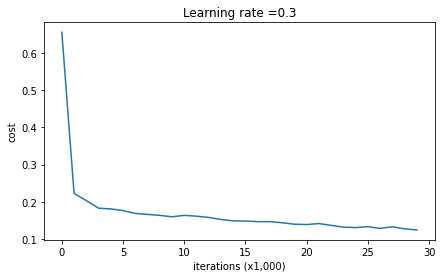

On the training set:
Accuracy: 94.79% 
On the test set:
Accuracy: 91.50% 


In [15]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Точность тренировки составляет 94.8% , а точность испытаний- 91,5%. Это **базовая модель** (вы увидите влияние регуляризации на эту модель).

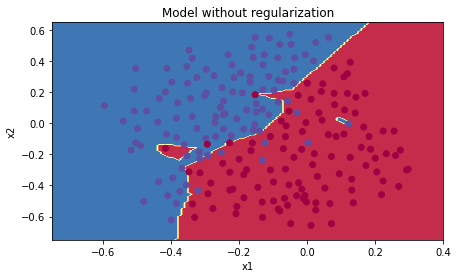

In [16]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## L2 Regularization

Стандартный способ избежать переобучения называется регуляризацией **L2**. Она состоит из соответствующего изменения вашей функции затрат, начиная с:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)}$$
К~~~>:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost}$$


**Упражнение**: реализуйте функцию `compute_cost_with_regularization()`, которая вычисляет стоимость, заданную формулой (2).

посчитайте $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , используя:
```python
np.sum(np.square(Wl))
```

In [17]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Реализуйте функцию затрат с регуляризацией L2. См. формулу (2) выше.
    
    A3 -- post-activation, выход прямого распространения,  shape (output size, number of examples)
    Y -- целевые значения переменных, shape (output size, number of examples)
    parameters - (dict) содержащий параметры модели
    
    return: cost - значение регуляризованной функции потерь см.(2)
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # Это дает вам кросс-энтропийную часть cost
    
    L2_regularization_cost = (np.sum(np.square(W1)) + np.sum( np.square(W2)) + np.sum(np.square(W3))) * lambd / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

In [18]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


Конечно, поскольку вы изменили стоимость, вы должны изменить и обратное распространение! Все градиенты должны быть рассчитаны с учетом этой новой стоимости.

**Упражнение**: внедрите изменения, необходимые в обратном распространении, чтобы учесть регуляризацию. Изменения касаются только dW1, dW2 и dW3. Для каждого, вам нужно добавить слагаемое-это градиент ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [19]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Реализует обратное распространение базовой модели, к которой мы добавили регуляризацию L2.
    
    X - входной набор данных, shape (2, number of examples)
    Y -- целевые значения переменных, shape (output size, number of examples)
    cache - cache output from forward_propagation()
    lambd --  гиперпараметр регуляризации, скаляр
    
    return: gradients - cловарь с градиентами по каждому параметру, активационным и предактивационным переменным
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y

    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd/m*W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))

    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd/m*W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))

    dW1 = 1./m * np.dot(dZ1, X.T) + lambd/m*W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

In [20]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("\ndW1 = \n", grads["dW1"])
print ("\ndW2 = \n", grads["dW2"])
print ("\ndW3 = ", *grads["dW3"])


dW1 = 
 [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]

dW2 = 
 [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]

dW3 =  [-1.77691347 -0.11832879 -0.09397446]


Теперь давайте запустим модель с регуляризацией L2 $(\lambda = 0.7)$. Функцию модели будем называть:
- `compute_cost_with_regularization` вместо `compute_cost`
- `backward_propagation_with_regularization` вместо `backward_propagation`

Cost after iteration 0: 0.6974
Cost after iteration 10000: 0.2685
Cost after iteration 20000: 0.2681


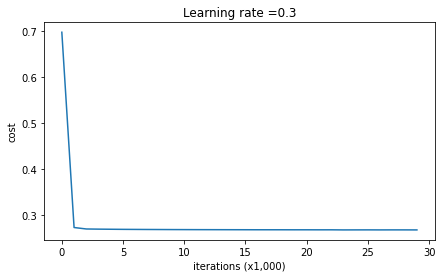

On the train set:
Accuracy: 93.84% 
On the test set:
Accuracy: 93.00% 


In [21]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Поздравляю, точность набора тестов возросла до 93%. Вы спасли французскую футбольную команду!

Вы больше не переобучены тренировочными данными. Давайте построим границу принятия решения.

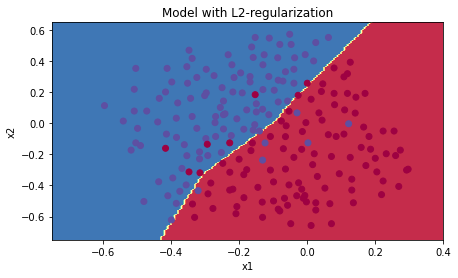

In [22]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Выводы**:
- Значение $\lambda$ - это гиперпараметр,который можно настроить с помощью  dev set.
- Регуляризация L2 делает границу вашего решения более гладкой. Если $\lambda$ слишком велик, то также можно "перегладить", что приведет к модели с большим смещением.

**Что L2-регуляризации, собственно, делает?**:

L2-регуляризация основана на предположении, что модель с малым весом проще, чем модель с большим весом.Таким образом, штрафуя квадратные значения весов в функции затрат, вы приводите все веса к меньшим значениям.Это становится слишком дорогим для стоимости иметь большие веса! Это приводит к более гладкой модели, в которой выходные данные изменяются медленнее, чем входные.

<font color='blue'>
**Что вы должны помнить* * -- последствия L2-регуляризации на:
- Расчет затрат:
    - К стоимости добавляется термин регуляризации
- Функция обратного распространения:
    - В градиентах существуют дополнительные члены относительно весовых матриц
- Весы в конечном итоге становятся меньше ("распад веса"):
    - Веса подталкиваются к меньшим значениям.

##  Dropout

Наконец, **dropout**  - это широко используемый метод регуляризации, специфичный для глубокого обучения.
**Он случайным образом отключает некоторые нейроны в каждой итерации.** Посмотрите эти два видео, чтобы понять, что это значит!



<center>
<video width="620" height="440" src="video-dropout/dropout1_kiank.mp4" type="video/mp4" controls>
</video>
</center>
<br>
<caption><center>  Drop-out на втором скрытом слое.<br> на каждой итерации вы закрываете (=устанавливаете на ноль) каждый нейрон слоя с вероятностью $1-keep\_prob$ или держите его с вероятностью $keep\_prob$ (здесь 50%). Отброшенные нейроны не способствуют обучению как в прямом, так и в обратном распространении итерации.</center></caption>

<center>
<video width="620" height="440" src="video-dropout/dropout2_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center>  Drop-out на первом и третьем скрытых слоях.<br> $1^{st}$ layer: мы отключаем в среднем 40% нейронов. $ 3^{rd} $ layer: мы отключаем в среднем 20% нейронов.</center></caption>

Чтобы понять dropout, рассмотрим этот разговор с другом:
- Друг: "Зачем тебе нужны все эти нейроны, чтобы тренировать свою сеть и классифицировать образы?".
- Вы: "потому что каждый нейрон содержит вес и может узнать конкретные особенности/детали / форму изображения. Чем больше у меня нейронов, тем больше возможностей усваивает моя модель!"
- Друг: "я вижу, но вы уверены, что ваши нейроны изучают разные особенности, а не все одинаковые?"
- Ты: "хорошая мысль... Нейроны в одном и том же слое на самом деле не разговаривают друг с другом. Должно быть определенно возможно, что они изучают одни и те же особенности изображения/формы/формы/детали... что было бы излишне. Должно же быть какое-то решение."


>Когда вы отключаете некоторые нейроны, вы фактически модифицируете свою модель. Идея отсева заключается в том, что на каждой итерации вы тренируете другую модель, которая использует только подмножество ваших нейронов. При отсеве ваши нейроны, таким образом, становятся менее чувствительными к активации одного другого специфического нейрона, потому что этот другой нейрон может быть выключен в любой момент.

### Forward propagation with dropout

**Упражнение**: реализуйте прямое распространение с dropout. Вы используете 3-слойную нейронную сеть и добавите отсев к первому и второму скрытым слоям. Мы не будем применять отсев к входному или выходному слою.

**Инструкции**:
Вы хотели бы отключить некоторые нейроны в первом и втором слоях. Для этого вам предстоит выполнить 4 шага:
1. Мы обсуждали создание переменной $d^{[1]}$ с той же формой, что и $a^{[1]}$, используя `np.random.rand()`  для случайного получения чисел от 0 до 1. Здесь вы будете использовать векторизованную реализацию, поэтому создайте случайную матрицу $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1] (m)}] $ той же размерности, что и $A^{[1]}$.
2. Установите для каждой записи $D^{[1]}$ значение 0 с вероятностью (`1-keep_prob`) или 1 с вероятностью (`keep_prob`), используя пороговые значения в $D^{[1]}$ соответствующим образом. Подсказка: чтобы установить все записи матрицы X равными 0 (если запись меньше 0,5) или 1 (Если запись больше 0,5), вы должны сделать следующее: `X = (X < 0,5)`. Обратите внимание, что 0 и 1 соответственно эквивалентны False и True.
3. Установите $A^{[1]}$ в $A^{[1]} * D^{[1]}$. (Вы отключаете некоторые нейроны). Вы можете думать о $D^{[1]}$ как о маске, так что, когда она умножается на другую матрицу, она закрывает некоторые значения.
4. Разделите $A^{[1]}$ на `keep_prob`. Делая это, вы гарантируете, что результат затрат все еще будет иметь ту же ожидаемую ценность, что и без  drop-out. (Этот метод также называется  inverted dropout.)


In [25]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Реализует прямое распространение: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    X -- входной набор данных, shape (2, number of examples)
    parameters - (dict) содержащий параметры "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix shape (20, 2)
                    b1 -- bias vector   shape (20, 1)
                    W2 -- weight matrix shape (3, 20)
                    b2 -- bias vector   shape (3, 1)
                    W3 -- weight matrix shape (1, 3)
                    b3 -- bias vector   shape (1, 1)
    keep_prob - вероятность сохранения активности нейрона во время отсева, скаляр
    
    Returns:
        A3 - последнее значение активации, выход прямого распространения,shape (1,1)
        cache - кортеж, информация, хранящаяся для вычисления обратного распространения
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)  
    ## Шаги 1-4 ниже соответствуют шагам 1-4, описанным выше.
    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Шаг 1: инициализация матрицы D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                               # Шаг 2: преобразуйте D1 в 0 или 1 (используя keep_prob в качестве порога)
    A1 = A1 * D1                                      # Шаг 3: выключите некоторые нейроны A1
    A1 = A1 / keep_prob                               # Шаг 4: масштабируйте значение нейронов, которые не были выключены

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    D2 = np.random.rand(A2.shape[0], A2.shape[1])     # Шаг 1: инициализация матрицы D2 = np.random.rand(..., ...)
    D2 = D2 < keep_prob                               # Шаг 2: преобразуйте D2 в 0 или 1 (используя keep_prob в качестве порога)
    A2 = A2 * D2                                      # Шаг 3: выключите некоторые нейроны A2
    A2 = A2 / keep_prob                               # Шаг 4: масштабируйте значение нейронов, которые не были выключены

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    return A3, cache

In [26]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = ", *A3)

A3 =  [0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]


### Backward propagation with dropout

**Упражнение**: реализуйте обратное распространение с dropout. Как и прежде, вы тренируете 3-х уровневую сеть. Добавьте отсев к первому и второму скрытым слоям, используя маски $D^{[1]}$ и $D^{[2]}$, хранящиеся в кэше.

**Инструкция**:
Обратное распространение с dropout на самом деле довольно просто. Вам придется выполнить 2 шага:
1. Ранее вы отключили некоторые нейроны во время прямого распространения, применив маску $D^{[1]}$ к `A1`. При обратном распространении вам придется отключить те же самые нейроны, повторно применив ту же самую маску $D^{[1]}$ к `dA1`.
2. Во время прямого распространения вы разделили `A1` на `keep_prob`. В метод обратного распространения ошибки,  придется делить`dA1` на `keep_prob`пять же (интерпретация исчисления состоит в том, что если $A^{[1]}$ масштабируется на `keep_prob`, то ее производная $dA^{[1]}$  тоже масштабируется от одного и того же `keep_prob`).

In [28]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Реализует обратное распространение нашей базовой модели, к которой мы добавили dropout.
    
    X - входной набор данных, shape (2, number of examples)
    Y -- целевые значения переменных, shape (output size, number of examples)
    cache - cache output from forward_propagation()
    lambd --  гиперпараметр регуляризации, скаляр
    
    return: gradients - cловарь с градиентами по каждому параметру, активационным и предактивационным переменным
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2              # Шаг 1: примените маску D2, чтобы отключить те же нейроны, что и во время прямого распространения
    dA2 = dA2 / keep_prob       # Шаг 2: масштабируйте значение нейронов, которые еще не были выключены

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1 * D1             # Шаг 1: примените маску D1, чтобы отключить те же нейроны, что и во время прямого распространения
    dA1 = dA1 / keep_prob      # Шаг 2: масштабируйте значение нейронов, которые еще не были выключены

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

Три выхода $(dW^{[l]}, db^{[l]}, dA^{[l]})$ вычисляются с использованием входных данных $dZ^{[l]}$. Вот необходимые вам формулы:
$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$

In [29]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n", gradients["dA1"])
print ("dA2 = \n", gradients["dA2"])

dA1 = 
 [[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
 [[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Теперь давайте запустим модель с dropout (`keep_prob = 0.86`). Это означает, что на каждой итерации вы отключаете каждый нейрон слоя 1 и 2 с вероятностью 24%.
- `forward_propagation_with_dropout` вместо `forward_propagation`.
- `backward_propagation_with_dropout` вместо `backward_propagation`.

Cost after iteration 0: 0.6544
Cost after iteration 10000: 0.06102
Cost after iteration 20000: 0.06058


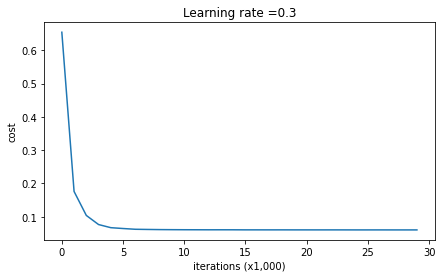

On the train set:
Accuracy: 92.89% 
On the test set:
Accuracy: 95.00% 


In [30]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Отсев работает отлично! Точность теста снова возросла (до 95%)! Ваша модель не слишком переобучена тренировочным набором и отлично справляется с тестовым набором. Французская футбольная команда будет Вам вечно благодарна!



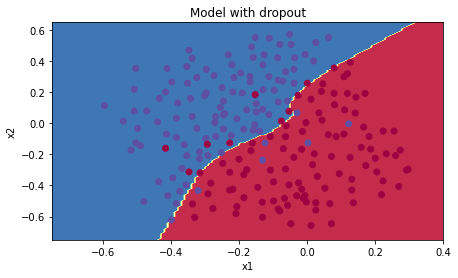

In [31]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Записка**:
- Распространенная ошибка при использовании dropout - это использование его как в обучении, так и в тестировании. Вы должны использовать dropout (случайное удаление узлов) только в обучении.
- Фреймворки глубокого обучения, такие как [tensorflow] (https://www.tensorflow.org/api_docs/python/tf/nn/dropout), [PaddlePaddle](http://doc.paddlepaddle.org/release_doc/0.9.0/doc/ui/api/trainer_config_helpers/attrs.html), [Керас](https://keras.io/layers/core/#dropout) или [кофе](http://caffe.berkeleyvision.org/tutorial/layers/dropout.html) приходят с реализацией отсева слоя. 


<font color='blue'>
**Что вы должны помнить об отсеве:**
- Отсев - это метод регуляризации.
- Вы используете отсев только во время обучения. Не используйте dropout (случайное удаление узлов) во время тестирования.
- Применяйте отсев как при прямом, так и при обратном распространении.
- Во время обучения разделите каждый слой отсева на keep_prob, чтобы сохранить одно и то же ожидаемое значение для активаций. Например, если keep_prob равен 0,5, то мы в среднем закрываем половину узлов, поэтому выходные данные будут масштабироваться на 0,5, так как только оставшаяся половина вносит свой вклад в решение. Деление на 0,5 равносильно умножению на 2. Следовательно, результат теперь имеет то же самое ожидаемое значение. Вы можете проверить, что это работает даже тогда, когда keep_prob имеет другие значения, чем 0.5.

## Вывод

**Вот результаты наших трех моделей***: 

<table> 
    <tr>
        <td>
        **model**
        </td>
        <td>
        **train accuracy**
        </td>
        <td>
        **test accuracy**
        </td>

    </tr>
        <td>
        3-layer NN without regularization
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        3-layer NN with L2-regularization
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with dropout
        </td>
        <td>
        93%
        </td>
        <td>
        95%
        </td>
    </tr>
</table> 

Обратите внимание, что регуляризация вредит производительности тренировочного набора! Это происходит потому, что она ограничивает способность сети переобучаться на обучающем наборе. Но поскольку это в конечном счете дает лучшую точность тестирования, это помогает вашей системе.

<font color='blue'>
**Что надо запомнить из этой тетради**:
- Регуляризация поможет вам уменьшить переобучение.
- Регуляризация приведет ваши веса к более низким значениям.
- Регуляризация L2 и отсев - это два очень эффективных метода регуляризации.